# Clean-Up

Import all libraries

In [2045]:
import numpy as np 
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 100)
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import requests
from bs4 import BeautifulSoup
import lxml.html as lh
%pip install geopandas
from geopandas.tools import geocode
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from statsmodels.formula.api import ols
%pip install folium
import folium
from scipy import stats

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import Nominatim API through the geopy library

In [28]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="jacksonville")

Import all CSVs: building sales data from 2017-2019, subway locations in all of nyc and data regarding demographics in each zip code.

In [3]:
subway_locations = pd.read_csv('/Users/avidanberman/Desktop/demo/Mod2Project/DOITT_SUBWAY_STATION_01_13SEPT2010.csv', index_col=0)

In [4]:
df_2019 = pd.read_csv('/Users/avidanberman/Desktop/demo/Mod2Project/2019_manhattan.csv', index_col=0)

In [5]:
df_2017 = pd.read_csv('/Users/avidanberman/Desktop/demo/Mod2Project/2017_manhattan.xlsx - Manhattan.csv', index_col=0)
df_2018 = pd.read_csv('/Users/avidanberman/Desktop/demo/Mod2Project/2018_manhattan.xlsx - Manhattan.csv', index_col=0)

In [6]:
zip_info = pd.read_csv('/Users/avidanberman/Desktop/demo/Mod2Project/zip_code_database.csv', index_col=0)

In [7]:
zip_info = pd.read_csv('/Users/avidanberman/Desktop/demo/Mod2Project/Zip_Code_Median_Income - Sheet1.csv', index_col=0)

Start Cleaning up the data from the subway location data

In [8]:
zip_info= zip_info.drop(columns= ['Location','National Rank','City'])

In [9]:
#function that will produce a list of subway geolocations
subway_geo= []
def subway_geo_loc():
    for x in range(len(subway_locations['the_geom'])):
        zx= subway_locations['the_geom'][x].split('(')[1]
        zx= zx.split(')')[:1]
        zx= zx[0].split(' ')
        for y in range(2):
            zx[y]= float(zx[y])
        subway_geo.append(zx)
    return subway_geo

In [10]:
subway_geo_loc()

[[-73.99106999861966, 40.73005400028978],
 [-74.00019299927328, 40.71880300107709],
 [-73.98384899986625, 40.76172799961419],
 [-73.97499915116808, 40.68086213682956],
 [-73.89488591154061, 40.66471445143568],
 [-73.90087000018522, 40.88466700064975],
 [-73.95806670661364, 40.800581558114956],
 [-73.94085899871263, 40.67991899941601],
 [-73.8987883783301, 40.74971952935675],
 [-73.92901818461539, 40.75196004401078],
 [-73.98740940202974, 40.71830605618619],
 [-73.89165772702445, 40.67802821447783],
 [-73.87962599910783, 40.68152000045683],
 [-73.84443500029684, 40.69516599823373],
 [-73.98177094440949, 40.690648119969794],
 [-73.82758075034528, 40.58326843810286],
 [-73.81365140419632, 40.58809156457325],
 [-73.89175225349464, 40.829987446384116],
 [-73.89661738461646, 40.822142131170786],
 [-73.90074099998965, 40.85609299881864],
 [-73.91013600050078, 40.84589999983414],
 [-73.91843200082253, 40.83376899862797],
 [-73.8456249984179, 40.75462199881262],
 [-73.86952700103515, 40.7491449

In [11]:
#Create a function that finds the distance to the closest subway
def distance_to_closest_subway(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

In [12]:
#Create a function that finds the location of the closest subway
from scipy.spatial.distance import cdist
def closest_node(node, nodes):
    return nodes[cdist([node], nodes).argmin()]

Merge data from 2019 with the new zip code data and start to clean up the data from 2019

In [13]:
df= df_2019.merge(zip_info, left_on='ZIP CODE\n', right_on='Zip Code', how='left', indicator=True)

In [772]:
#Create a list of building codes that refer to multifamily and mixed-use properties
buildingclasses= ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','S0','S1','S2','S3','S4','S5','S6','S7','S8','S9']

In [15]:
#Create a column which says if the row is a multifamily/mixed-use property or not
df['Want'] = np.where(df['BUILDING CLASS AT TIME OF SALE\n'].isin(buildingclasses), 1, 0)

In [16]:
#create a new data frame of just the mutlifamily and mixed-use properties
dfmixed_multi= df[df['Want'] == 1]

In [17]:
#Drop all columns that are not needed
dfmixed_multi= dfmixed_multi.drop(columns= ['Want','TAX CLASS AS OF FINAL ROLL 18/19','BUILDING CLASS AS OF FINAL ROLL 18/19', 'EASE-MENT\n', 'APARTMENT NUMBER\n', 'BLOCK\n', 'LOT\n', 'TAX CLASS AT TIME OF SALE\n', '_merge','Zip Code'])

In [18]:
#Some listed sales are passed along for inheritance, so switch zero's to NaN's and then remove NaN's
dfmixed_multi['SALE PRICE\n'].replace('0',np.nan, inplace= True)
dfmixed_multi.dropna(subset = ["SALE PRICE\n"], inplace=True)

In [20]:
#Drop all rows that have NaN's in Population
dfmixed_multi.dropna(subset = ["Population"], inplace=True)

In [21]:
#Drop all rows that have NaN's in Residential units
dfmixed_multi.dropna(subset = ["RESIDENTIAL UNITS\n"], inplace=True)

In [22]:
#Create a Column that we will eventually use to search for Geolocation
dfmixed_multi['address']= dfmixed_multi.apply(lambda x: x['ADDRESS\n'] + ', New York ', axis=1)

In [23]:
#Continued process to get geo location
dfmixed_multi['full_address']= dfmixed_multi.apply(lambda x: x['address']+ str(x['ZIP CODE\n']), axis=1)

In [24]:
#Create and run a function that will get the Latitude for each location
def get_lat (address):
    try:
        loca= geolocator.geocode(address).latitude
    except: 
        return np.NaN
    return loca
dfmixed_multi['lat']= dfmixed_multi.address.apply(lambda x: get_lat(x))

In [30]:
#Create and run a function that will get the Longitude for each location
def get_long (address):
    try:
        loca= geolocator.geocode(address).longitude
    except: 
        return np.NaN
    return loca
dfmixed_multi['long']= dfmixed_multi.address.apply(lambda x: get_long(x))

In [32]:
#Drop all rows that we couldnt find geolocation
dfmixed_multi.dropna(subset = ["lat"], inplace=True)

In [33]:
#Create a column that has the full geolocation of the property.
dfmixed_multi['geoloc1']= dfmixed_multi.apply(lambda x: [x.long, x.lat], axis=1)

In [34]:
#Create a column that finds the closest subway for each location
dfmixed_multi['closest_subway']= dfmixed_multi.geoloc1.apply(lambda x: closest_node(x, subway_geo))

In [35]:
#Create a column that finds the distance from the closest subway
dfmixed_multi['distance_from_subway']= dfmixed_multi.geoloc1.apply(lambda x: distance_to_closest_subway(x, subway_geo))

Go through the same process just for 2018 and 2017

In [36]:
df18= df_2018.merge(zip_info, left_on='ZIP CODE\n', right_on='Zip Code', how='left', indicator=True)
df17= df_2017.merge(zip_info, left_on='ZIP CODE\n', right_on='Zip Code', how='left', indicator=True)

In [37]:
df18['BUILDING CLASS AT TIME OF SALE\n']= df18.apply(lambda x: x['BUILDING CLASS AT TIME OF SALE\n'].strip(), axis=1)

In [38]:
df18['Want'] = np.where(df18['BUILDING CLASS AT TIME OF SALE\n'].isin(buildingclasses), 1, 0)

In [40]:
dfmixed_multi18= df18[df18['Want'] == 1]

In [41]:
dfmixed_multi18= dfmixed_multi18.drop(columns= ['Want','TAX CLASS AS OF FINAL ROLL 18/19','BUILDING CLASS AS OF FINAL ROLL 18/19', 'APARTMENT NUMBER\n', 'BLOCK\n', 'LOT\n', 'TAX CLASS AT TIME OF SALE\n', '_merge','Zip Code'])

In [42]:
dfmixed_multi18['SALE PRICE\n'].replace(0.00,np.nan, inplace= True)

In [43]:
dfmixed_multi18.dropna(subset = ["SALE PRICE\n"], inplace=True)

In [44]:
dfmixed_multi18.dropna(subset = ["Population"], inplace=True)

In [45]:
dfmixed_multi18.dropna(subset = ["RESIDENTIAL UNITS\n"], inplace=True)

In [46]:
dfmixed_multi18['address']= dfmixed_multi18.apply(lambda x: x['ADDRESS\n'] + ', New York ', axis=1)

In [48]:
dfmixed_multi18['full_address']= dfmixed_multi18.apply(lambda x: x['address']+ str(x['ZIP CODE\n']), axis=1)

In [49]:
dfmixed_multi18['lat']= dfmixed_multi18.full_address.apply(lambda x: get_lat(x))

In [50]:
dfmixed_multi18['long']= dfmixed_multi18.full_address.apply(lambda x: get_long(x))

In [51]:
dfmixed_multi18.dropna(subset = ["lat"], inplace=True)

In [52]:
dfmixed_multi18['geoloc1']= dfmixed_multi18.apply(lambda x: [x.long, x.lat], axis=1)

In [53]:
dfmixed_multi18['closest_subway']= dfmixed_multi18.geoloc1.apply(lambda x: closest_node(x, subway_geo))

In [54]:
dfmixed_multi18['distance_from_subway']= dfmixed_multi18.geoloc1.apply(lambda x: distance_to_closest_subway(x, subway_geo))

In [58]:
df17['BUILDING CLASS AT TIME OF SALE\n']= df17.apply(lambda x: x['BUILDING CLASS AT TIME OF SALE\n'].strip(), axis=1)

In [59]:
df17['Want'] = np.where(df17['BUILDING CLASS AT TIME OF SALE\n'].isin(buildingclasses), 1, 0)

In [64]:
dfmixed_multi18.drop(columns= 'Want', inplace= True)

/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [65]:
dfmixed_multi17= df17[df17['Want'] == 1]

In [67]:
dfmixed_multi17= dfmixed_multi17.drop(columns= ['Want', 'APARTMENT NUMBER\n', 'BLOCK\n', 'LOT\n', 'TAX CLASS AT TIME OF SALE\n', '_merge','Zip Code'])

In [68]:
dfmixed_multi17['SALE PRICE\n'].replace(0.00,np.nan, inplace= True)

In [69]:
dfmixed_multi17.dropna(subset = ["SALE PRICE\n"], inplace=True)

In [70]:
dfmixed_multi17.dropna(subset = ["Population"], inplace=True)

In [71]:
dfmixed_multi17.dropna(subset = ["RESIDENTIAL UNITS\n"], inplace=True)

In [72]:
dfmixed_multi17['address']= dfmixed_multi17.apply(lambda x: x['ADDRESS\n'] + ', New York ', axis=1)

In [73]:
dfmixed_multi17['full_address']= dfmixed_multi17.apply(lambda x: x['address']+ str(x['ZIP CODE\n']), axis=1)

In [74]:
dfmixed_multi17['lat']= dfmixed_multi17.full_address.apply(lambda x: get_lat(x))

In [75]:
dfmixed_multi17['long']= dfmixed_multi17.full_address.apply(lambda x: get_long(x))

In [76]:
dfmixed_multi17.dropna(subset = ["lat"], inplace=True)

In [77]:
dfmixed_multi17['geoloc1']= dfmixed_multi17.apply(lambda x: [x.long, x.lat], axis=1)

In [78]:
dfmixed_multi17['closest_subway']= dfmixed_multi17.geoloc1.apply(lambda x: closest_node(x, subway_geo))

In [79]:
dfmixed_multi17['distance_from_subway']= dfmixed_multi17.geoloc1.apply(lambda x: distance_to_closest_subway(x, subway_geo))

Concatenate the three data frames together to make one big data frame to work on

In [1973]:
df_final= pd.concat([dfmixed_multi,dfmixed_multi18,dfmixed_multi17])

In [1974]:
#Drop all unnecessary columns
df_final.drop(columns= ['TAX CLASS AS OF FINAL ROLL 18/19','BLOCK\n','LOT\n', 'BUILDING CLASS AS OF FINAL ROLL 18/19', 'APARTMENT NUMBER\n','TAX CLASS AT TIME OF SALE\n','Zip Code','_merge','TAX CLASS AS OF FINAL ROLL 17/18','BUILDING CLASS AS OF FINAL ROLL 17/18'], inplace= True)

Save the data frame to csv to be able to access without having to make calls to Nominatim API.

In [1975]:
#Unhash and run to save
#df_final.to_csv('/Users/avidanberman/Desktop/demo/Mod2Project/df_final.csv')

Clean up columns to make sure they run as Floats/Integers instead of string

In [1976]:
df_final['LAND SQUARE FEET\n']= df_final['LAND SQUARE FEET\n'].map(lambda x: x.replace('$', '')).map(lambda x: x.replace(',', '')).map(lambda x: x.replace('-', '0')).map(lambda x: int(x))

In [1977]:
df_final['GROSS SQUARE FEET\n']= df_final['GROSS SQUARE FEET\n'].map(lambda x: x.replace('$', '')).map(lambda x: x.replace(',', '')).map(lambda x: x.replace('-', '0')).map(lambda x: int(x))

In [1978]:
df_final['SALE PRICE\n']= df_final['SALE PRICE\n'].map(lambda x: x.replace('$', '')).map(lambda x: x.replace(',', '')).map(lambda x: x.replace('-', '0')).map(lambda x: float(x))

In [1979]:
df_final['Population']= df_final['Population'].map(lambda x: str(x)).map(lambda x: x.replace('$', '')).map(lambda x: x.replace(',', '')).map(lambda x: x.replace('-', '0')).map(lambda x: float(x))

In [1980]:
df_final['Avg. Income/H/hold']= df_final['Avg. Income/H/hold'].map(lambda x: str(x)).map(lambda x: x.replace('$', '')).map(lambda x: x.replace(',', '')).map(lambda x: x.replace('-', '0')).map(lambda x: float(x))


In [1981]:
#Remove outliers from Sale Price
df_final=df_final[df_final['SALE PRICE\n']<10000000.0]
df_final=df_final[df_final['SALE PRICE\n'] >100000]

In [1982]:
#Create a new column that gives the year the building was sold
df_final['year_sold'] = pd.DatetimeIndex(df_final['SALE DATE\n']).year

In [1983]:
#Create a new column that gives the age of the building
df_final['age']= df_final['year_sold']-df_final['YEAR BUILT\n']

In [1984]:
df_final['RESIDENTIAL UNITS\n']= df_final['RESIDENTIAL UNITS\n'].map(lambda x: str(x)).map(lambda x: x.replace('$', '')).map(lambda x: x.replace(',', '')).map(lambda x: x.replace('-', '0')).map(lambda x: float(x))

Create new data frame with dummies for Zip code and Building class

In [1985]:
df_final2 = pd.concat([df_final, pd.get_dummies(df_final['ZIP CODE\n'])], 1)

In [1986]:
df_final2 = pd.concat([df_final2, pd.get_dummies(df_final['BUILDING CLASS AT TIME OF SALE\n'])], 1)

Drop all unnecessary columns from both data frames

In [1987]:
df_final2= df_final2.drop(columns= ['ZIP CODE\n','BUILDING CLASS AT TIME OF SALE\n','YEAR BUILT\n','ADDRESS\n', 'BUILDING CLASS CATEGORY\n','address', 'lat','long', 'geoloc1', 'closest_subway','SALE DATE\n', 'TOTAL UNITS\n', 'full_address'])

In [1988]:
df_final= df_final.drop(columns= ['lat','long','BUILDING CLASS AT TIME OF SALE\n','YEAR BUILT\n','ADDRESS\n', 'BUILDING CLASS CATEGORY\n','address', 'geoloc1', 'closest_subway', 'TOTAL UNITS\n', 'full_address'])

In [1989]:
df_final2['distance_from_subway'].replace(np.NaN, df_final2['distance_from_subway'].mean(), inplace= True)
df_final2= df_final2[df_final2['COMMERCIAL UNITS\n'] < 1]
df_final2.drop(columns= ['COMMERCIAL UNITS\n','S0','S1','S2','S3','S4','S5','S9'], inplace= True)

Drop all rows that have NaN's for Population

In [1990]:
df_final2.dropna(subset = ["Population"], inplace=True)
df_final.dropna(subset = ["Population"], inplace=True)

In [1991]:
df_final['distance_from_subway'].replace(np.NaN, df_final['distance_from_subway'].mean(), inplace= True)
df_final= df_final[df_final['COMMERCIAL UNITS\n'] < 1]
df_final.drop(columns= ['COMMERCIAL UNITS\n'], inplace= True)

Remove any additional outliers:

In [1992]:
df_final2.describe()

,RESIDENTIAL UNITS\n,LAND SQUARE FEET\n,GROSS SQUARE FEET\n,SALE PRICE\n,Population,Avg. Income/H/hold,distance_from_subway,year_sold,age,10001,10002,10003,10006,10007,10009,10010,10011,10012,10013,10014,10016,10018,10019,10021,10022,10023,10024,10025,10026,10027,10028,10029,10030,10031,10032,10033,10034,10035,10036,10037,10038,10039,10040,10065,10075,10128,10463,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
count,1090.000000,1090.000000,1090.000000,1.090000e+03,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.0,1090.0,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.0,1090.000000,1090.000000,1090.0,1090.0,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.0,1090.000000,1090.000000
mean,4.189908,1004.326606,2971.803670,2.279044e+06,50051.123853,50076.915596,248.988745,2017.966055,106.928440,0.003670,0.012844,0.049541,0.0,0.0,0.068807,0.002752,0.067890,0.034862,0.007339,0.084404,0.012844,0.002752,0.016514,0.019266,0.013761,0.033945,0.083486,0.039450,0.050459,0.057798,0.052294,0.014679,0.036697,0.051376,0.026606,0.012844,0.008257,0.025688,0.038532,0.003670,0.0,0.007339,0.004587,0.0,0.0,0.049541,0.005505,0.071560,0.091743,0.029358,0.054128,0.093578,0.084404,0.569725,0.0,0.003670,0.001835
std,7.076889,1404.130232,4814.294109,2.447054e+06,19360.653857,21529.912075,80.255627,0.493990,60.086947,0.060495,0.112653,0.217095,0.0,0.0,0.253242,0.052414,0.251672,0.183515,0.085395,0.278120,0.112653,0.052414,0.127499,0.137522,0.116553,0.181171,0.276743,0.194751,0.218990,0.233469,0.222721,0.120319,0.188104,0.220865,0.161001,0.112653,0.090533,0.158276,0.192565,0.060495,0.0,0.085395,0.067604,0.0,0.0,0.217095,0.074022,0.257876,0.288795,0.168885,0.226375,0.291374,0.278120,0.495342,0.0,0.060495,0.042816
min,0.000000,0.000000,0.000000,1.020830e+05,4255.000000,14896.000000,0.000000,2017.000000,16.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,5.036250e+05,32667.000000,24285.000000,247.883028,2018.000000,98.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.000000,9.999190e+05,53673.000000,58313.000000,247.883028,2018.000000,108.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000
75%,6.750000,1947.000000,4431.500000,3.374250e+06,60221.000000,70031.000000,247.883028,2018.000000,118.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0

In [1993]:
df_final2= df_final2[(df_final2['RESIDENTIAL UNITS\n']<16) & (df_final2['age']<200)]

In [1994]:
df_final= df_final[(df_final['RESIDENTIAL UNITS\n']<16) & (df_final['age']<200)]

Buildings with just 1 residential unit got switched to 0 units, so running a where function to switch the zero's to 1

In [1995]:
df_final2['RESIDENTIAL UNITS\n']= np.where(df_final2['RESIDENTIAL UNITS\n']==0, 1, df_final2['RESIDENTIAL UNITS\n'])
df_final['RESIDENTIAL UNITS\n']= np.where(df_final['RESIDENTIAL UNITS\n']==0, 1, df_final['RESIDENTIAL UNITS\n'])

# Exploration and Visualization

In [2017]:
#Last section we saw the colinear relationship between Land sq/ft and Gross sq/ft so we will remove Land sq/ft from our visuaization dataframe
df_final=df_final.drop(columns=['LAND SQUARE FEET\n'])

Heatmap of features

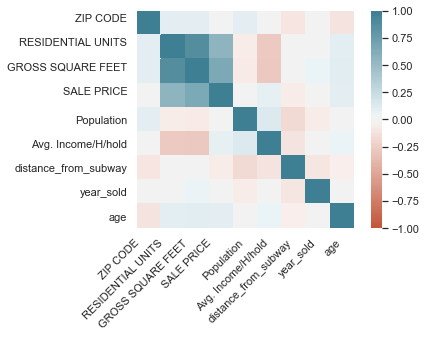

In [2018]:
corr = df_final.corr()
ax = sns.heatmap(
    corr,
    vmin= -1, vmax= 1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

The heatmap shows that the number of residential and commercial units along with gross square feet have the greatest impact on sales price.

1) What is the relationship between distance from subway and sale price?

In [2019]:
df_final['Price_sqft']= (df_final["SALE PRICE\n"])/(df_final["GROSS SQUARE FEET\n"])

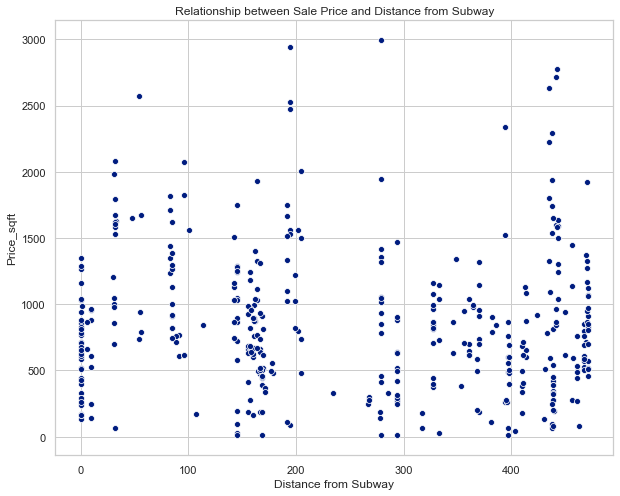

In [2020]:
scattering, names = plt.subplots(figsize=(10, 8))
regress = sns.scatterplot(x='distance_from_subway', y='Price_sqft', data= df_final3)
regress.set(xlabel='Distance from Subway', ylabel='Price_sqft', title='Relationship between Sale Price and Distance from Subway')
scattering = plt.gcf();

There is technically a negative correlation between Price/sqft and the distance from the closest subway, however the relationship is very weak.

2) What is the relationship between gross square feet and sale price

In [2021]:
#Get rid of 0's
df_final['GROSS SQUARE FEET\n'].replace(0,np.nan, inplace= True)
df_final.dropna(subset = ["GROSS SQUARE FEET\n"], inplace=True)

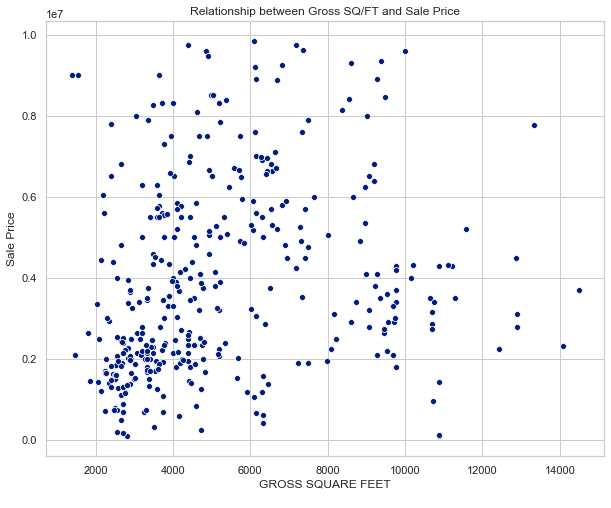

In [2022]:
scattering, names = plt.subplots(figsize=(10, 8))
regress = sns.scatterplot(x='GROSS SQUARE FEET\n', y='SALE PRICE\n', data= df_final)
regress.set(xlabel='GROSS SQUARE FEET\n', ylabel='Sale Price', title='Relationship between Gross SQ/FT and Sale Price')
scattering = plt.gcf();

There is a positive correlation between Gross Square Feet and Sale Price

3) Does Average household income have an effect on sales price (per square foot)?

In [2023]:
df_zipcode = df_final.groupby('ZIP CODE\n').aggregate(np.mean)

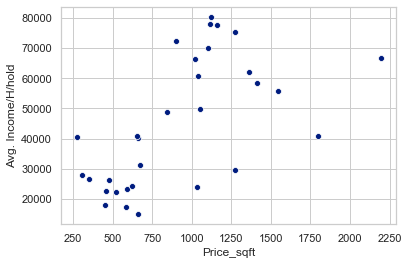

In [2024]:
sns.scatterplot(x="Price_sqft", y='Avg. Income/H/hold', data=df_zipcode);

There is a positive correlation between avg income and price/sqft

4) Do similar amount of sales happen per year?

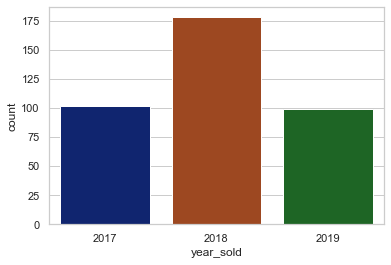

In [2025]:
sns.countplot(x='year_sold', data=df_final);

2017 and 2019 had similar amount of sales but there was a major increase in sales in 2018

5) Did the Housing Stability and Tenant Protection Act passed in July of 2019 have an effect on number of sales?

In [2026]:
df_final['month_year'] = pd.to_datetime(df_final['SALE DATE\n']).dt.to_period('M')

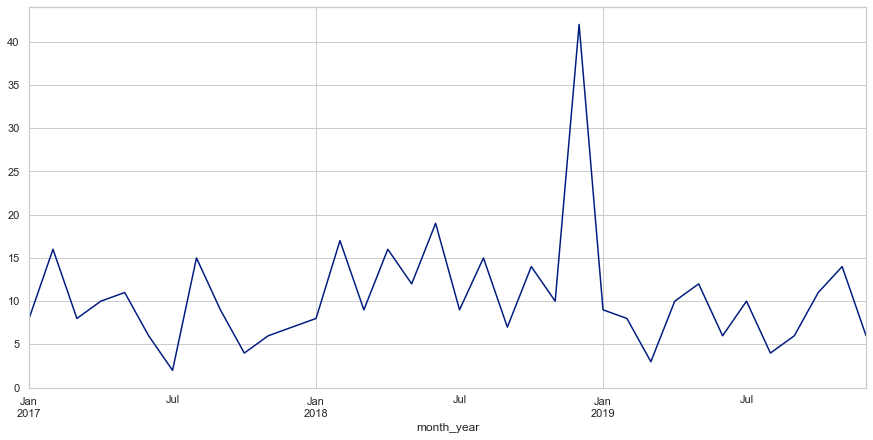

In [2027]:
fig, ax = plt.subplots(figsize=(15,7))
df_final.groupby(['month_year']).count()['ZIP CODE\n'].plot(ax=ax);

Yes, we saw an immediate decrease in sales. There was a bump at the end of the year as buyers and sellers want to close sales in time to apply it to their taxes for that year but the jump wasn't particularly large and tailed off in December of 2019.

6) How much should we expect a Pre-War building (built before 1940) to be sold for in 2019?

In [2043]:
df_prewar2019=df_final[(df_final['age']>(2019-1940))& (df_final['year_sold'] == 2019)]['SALE PRICE\n']

In [2046]:
print('Mean:', df_prewar2019.mean(),'Confidence Interval:', stats.norm.interval(alpha = .95, loc = df_prewar2019.mean(), scale = len(df_prewar2019)))

Mean: 4025462.1041666665 Confidence Interval: (4025273.9476241507, 4025650.2607091824)


We can say with 95% certainty that the confidence interval contains how much a pre-war building should sell for if its sold in 2019

7) Is the amount of residential units in a building independent of the size of the properties population?

In [2039]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# contingency table
table = [df_final['RESIDENTIAL UNITS\n'], df_final['Population']]
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

dof=378
probability=0.950, critical=424.334, stat=1469.196
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


We reject the null hypothesis that the two features are independent

8) Is there a difference in Gross sqft per residential unit in populations that have an income greater than 58,313 and lower than 58,313?

In [2055]:
new_df= df_final[["GROSS SQUARE FEET\n","RESIDENTIAL UNITS\n","Avg. Income/H/hold"]]
new_df

,GROSS SQUARE FEET\n,RESIDENTIAL UNITS\n,Avg. Income/H/hold
3,3600.0,3.0,40176.0
5,7989.0,12.0,40176.0
8,4154.0,4.0,40176.0
9,3491.0,4.0,40176.0
12,6294.0,5.0,40176.0
...,...,...,...
16905,4109.0,6.0,78066.0
16906,6674.0,10.0,78066.0
17857,5220.0,3.0,49733.0
18236,3300.0,3.0,26237.0


In [2056]:
new_df['Gross per unit']= new_df['GROSS SQUARE FEET\n']/new_df['RESIDENTIAL UNITS\n']

/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [2060]:
new_df_g_avg= new_df[new_df['Avg. Income/H/hold']> 58313]['Gross per unit']
new_df_l_avg= new_df[new_df['Avg. Income/H/hold']< 58313]['Gross per unit']

In [2061]:
def two_sample_two_tail_ttest(a, b):
    return stats.ttest_ind(a, b, axis=0, equal_var= True, nan_policy='omit')
two_sample_two_tail_ttest(new_df_g_avg, new_df_l_avg)

Ttest_indResult(statistic=-0.03949885327696559, pvalue=0.9685138001064783)

pvalue is greater than .05, therefore we fail to reject the null hypothesis that gross square feet per unit is equal in zipcodes that make more than $58313 

and less than $58313

# Test Train Split Model

Create a function to run the train test split model

In [1996]:
def test_train_split_model(abc):
    target = abc['SALE PRICE\n']
    df_features= abc.drop(columns= ['SALE PRICE\n'])
    X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=34,test_size=0.3)
    lm_3 = LinearRegression()
    #fit the linear regression to the data
    lm_3 = lm_3.fit(X_train, y_train)
    y_train_pred = lm_3.predict(X_train)
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    print('Training Root Mean Squared Error:' , train_rmse)
    # use fitted model to predict on test data
    y_pred = lm_3.predict(X_test)
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('Testing Root Mean Squared Error:' , test_rmse)
    print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))
    print('R^2 for training data:', lm_3.score(X_train, y_train))
    print('R^2 for testing data:', lm_3.score(X_test, y_test))
    print('Testing Error:', test_rmse/y_train.std())
    return

Based on the correlation chart, Land and Gross Sq/FT are colinear therefore we need to remove one for accurate modeling

In [1997]:
df_final2.corr()

,RESIDENTIAL UNITS\n,LAND SQUARE FEET\n,GROSS SQUARE FEET\n,SALE PRICE\n,Population,Avg. Income/H/hold,distance_from_subway,year_sold,age,10001,10002,10003,10006,10007,10009,10010,10011,10012,10013,10014,10016,10018,10019,10021,10022,10023,10024,10025,10026,10027,10028,10029,10030,10031,10032,10033,10034,10035,10036,10037,10038,10039,10040,10065,10075,10128,10463,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
RESIDENTIAL UNITS\n,1.000000,0.836378,0.879751,0.558554,-0.047755,-0.261028,0.023645,0.025046,0.103295,-0.017160,-0.045789,-0.054824,NaN,NaN,-0.022889,-0.034663,-0.079064,-0.108961,-0.053055,-0.116540,0.070982,0.101044,-0.068471,-0.079475,-0.011429,0.001640,0.012261,-0.055663,0.246054,0.127431,-0.062110,0.047989,0.166329,0.070089,0.023097,-0.019228,-0.017160,0.067630,-0.074432,-0.008250,NaN,-0.004542,0.062244,NaN,NaN,-0.015061,0.065229,-0.015623,0.439212,0.113270,0.058788,0.531557,0.465759,-0.806249,NaN,-0.040045,0.010511
LAND SQUARE FEET\n,0.836378,1.000000,0.914902,0.660709,-0.058853,-0.317210,0.012161,0.071611,0.078617,0.013736,-0.061308,-0.058306,NaN,NaN,-0.061287,-0.040134,-0.087605,-0.112264,-0.061428,-0.115752,0.072788,0.081313,-0.073544,-0.089685,0.007078,-0.041588,-0.000111,-0.042486,0.271911,0.147468,-0.072252,0.072577,0.151216,0.085670,0.028467,-0.019983,-0.018503,0.121332,-0.092026,0.048725,NaN,-0.017805,0.143930,NaN,NaN,-0.049336,0.195306,0.319888,0.318992,0.181455,0.243625,0.443063,0.343902,-0.933499,NaN,-0.046366,0.019936
GROSS SQUARE FEET\n,0.879751,0.914902,1.000000,0.648739,-0.064928,-0.274347,0.024877,0.057096,0.114268,-0.014716,-0.041647,-0.054953,NaN,NaN,-0.023889,-0.035929,-0.075797,-0.098402,-0.054993,-0.126819,0.080640,0.070476,-0.068773,-0.080003,-0.001086,-0.019118,0.010107,-0.031824,0.349230,0.090816,-0.068227,0.042017,0.141682,0.033304,0.024596,-0.040572,-0.022930,0.084301,-0.077540,0.005036,NaN,-0.002071,0.066277,NaN,NaN,-0.027893,0.091160,0.174968,0.373370,0.112729,0.140972,0.591238,0.259207,-0.835702,NaN,-0.041508,0.006176
SALE PRICE\n,0.558554,0.660709,0.648739,1.000000,-0.008263,0.084244,-0.051078,0.032043,0.097126,0.017321,-0.027182,0.010132,NaN,NaN,-0.073325,-0.037414,0.010945,-0.031029,0.003849,0.036807,0.110760,0.073852,-0.044149,-0.054123,0.029816,0.014540,0.128289,0.010790,0.071356,-0.027910,-0.032807,0.010549,-0.031735,-0.025144,-0.051598,-0.052365,0.010528,0.016502,-0.064572,-0.027249,NaN,-0.027428,-0.000250,NaN,NaN,-0.001199,-0.008709,0.231453,0.240962,0.171880,0.207966,0.206140,0.294640,-0.680159,NaN,0.021553,0.010924
Population,-0.047755,-0.058853,-0.064928,-0.008263,1.000000,0.137319,-0.169829,-0.048948,0.018059,-0.106406,0.215166,0.045093,NaN,NaN,0.125453,-0.066362,-0.045525,-0.244608,-0.107489,-0.280574,0.007703,-0.105311,-0.088157,0.374820,-0.122338,0.124797,0.187355,0.490672,-0.230553,0.082894,-0.058887,0.162489,-0.239363,0.114622,0.097626,0.047733,-0.026497,-0.147439,-0.327541,-0.093027,NaN,-0.121802,-0.007535,NaN,NaN,0.118252,0.051366,0.008274,0.046200,0.006263,-0.068941,-0.138690,0.078346,0.051563,NaN,-0.079566,-0.039624
Avg. Income/H/hold,-0.261028,-0.317210,-0.274347,0.084244,0.137319,1.000000,-0.111569,-0.015642,0.050772,-0.029467,-0.149098,0.106232,NaN,NaN,-0.139288,0.029423,0.142080,0.068210,-0.049300,0.230489,0.078970,-0.004635,0.028330,0.158801,0.169125,0.195878,0.396718,-0.011228,-0.303367,-0.329219,0.290017,-0.164680,-0.296169,-0.265798,-0.155460,-0.100357,-0.063216,-0.279116,-0.094242,-0.062163,NaN,-0.131027,-0.047932,NaN,NaN,0.203725,-0.030749,-0.146446,-0.043171,-0.008341,-0.141009,-0.196413,-0.060592,0.320503,NaN,-0.007730,-0.075012
distance_from_subway,0.023645,0.012161,0.024877,-0.051078,-0.169829,-0.111569,1.000000,-0.088139,-0.042093,0.037433,-0.030115,-0.034570,NaN,NaN,-0.065902,-0.001536,0.120415,0.006078,0.031773,0.012574,-0.170850,0.110124,-0.009319,0.017619,-0.038018,-0.041180,-0.140661,-0.068289,-0.000112,0.024915,0.086466,-0.011457,0.121890,-0.037112,0.031083,-0.011575,-0.001775,0.189500,0.015633,-0.001536,NaN,-0.002352,0.042594,NaN,NaN,-0.005944,-0.157597,-0.0550

In [1998]:
df_final_no_land= df_final2.drop(columns=['LAND SQUARE FEET\n'])

In [1999]:
df_final_no_gross= df_final2.drop(columns=['GROSS SQUARE FEET\n'])

In [2000]:
test_train_split_model(df_final_no_gross)

Training Root Mean Squared Error: 1355390.3922727974
Testing Root Mean Squared Error: 1293712.1882476094
Training:  1355390 vs. Testing:  1293712
R^2 for training data: 0.6359608436856807
R^2 for testing data: 0.5851403278730192
Testing Error: 0.575489983981941


In [2001]:
test_train_split_model(df_final_no_land)

Training Root Mean Squared Error: 1300405.6097150669
Testing Root Mean Squared Error: 1272210.461505002
Training:  1300405 vs. Testing:  1272210
R^2 for training data: 0.6648980445097078
R^2 for testing data: 0.5988158141785431
Testing Error: 0.5659252380584692


The Dateframe with no land sq/ft performed better so we will use that as our new data frame

In [2002]:
df_final2= df_final_no_land

Create different dataframes to test out if features created have an effect on the performance of the model.

In [2003]:
df_final_nosubway= df_final2.drop(columns=['distance_from_subway'])

In [2004]:
df_final_no_age= df_final2.drop(columns=['age'])

In [2005]:
df_final_noage_nosubway= df_final2.drop(columns=['age', 'distance_from_subway','year_sold'])

In [2006]:
df_final_noyear_sold= df_final2.drop(columns=['year_sold'])

In [2007]:
test_train_split_model(df_final2)

Training Root Mean Squared Error: 1300405.6097150669
Testing Root Mean Squared Error: 1272210.461505002
Training:  1300405 vs. Testing:  1272210
R^2 for training data: 0.6648980445097078
R^2 for testing data: 0.5988158141785431
Testing Error: 0.5659252380584692


In [2008]:
test_train_split_model(df_final_nosubway)

Training Root Mean Squared Error: 1301598.994219329
Testing Root Mean Squared Error: 1264350.7293984252
Training:  1301598 vs. Testing:  1264350
R^2 for training data: 0.6642827149924848
R^2 for testing data: 0.6037575436578959
Testing Error: 0.5624289448757921


In [2009]:
test_train_split_model(df_final_no_age)

Training Root Mean Squared Error: 1301125.4290014228
Testing Root Mean Squared Error: 1264598.0135703208
Training:  1301125 vs. Testing:  1264598
R^2 for training data: 0.6645269608901592
R^2 for testing data: 0.6036025327619376
Testing Error: 0.5625389458214552


In [2010]:
test_train_split_model(df_final_noage_nosubway)

Training Root Mean Squared Error: 1302545.9892718177
Testing Root Mean Squared Error: 1257185.2339862925
Training:  1302545 vs. Testing:  1257185
R^2 for training data: 0.6637940264429603
R^2 for testing data: 0.6082360920295116
Testing Error: 0.5592414732902175


In [2011]:
test_train_split_model(df_final_noyear_sold)

Training Root Mean Squared Error: 1300594.0100405465
Testing Root Mean Squared Error: 1272675.2106230455
Training:  1300594 vs. Testing:  1272675
R^2 for training data: 0.6648009395905505
R^2 for testing data: 0.5985226487659836
Testing Error: 0.5661319752794122


We have found that the model that doesn't have the distance from subway and the age of the building performs the best.

In [2012]:
test_train_split_model(df_final_noage_nosubway)

Training Root Mean Squared Error: 1302545.9892718177
Testing Root Mean Squared Error: 1257185.2339862925
Training:  1302545 vs. Testing:  1257185
R^2 for training data: 0.6637940264429603
R^2 for testing data: 0.6082360920295116
Testing Error: 0.5592414732902175


# Lasso Model

We will now try and run a Lasso model to see if it performs better than what we already have 

In [2013]:
#Create a function for Lasso Model
def lasso_model_T(abc):
    target = abc['SALE PRICE\n']
    df_features= abc.drop(columns= ['SALE PRICE\n'])
    X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=34,test_size=0.3)
    lasso = Lasso(alpha=0.01, normalize=True)
    lasso.fit(X_train,y_train)
    y_train_pred = lasso.predict(X_train)
    y_pred = lasso.predict(X_test)
    train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('Training Error: '+ str(train_rmse))
    print('Testing Error: '+ str(test_rmse))
    return

In [2014]:
lasso_model_T(df_final2)

Training Error: 905353.8340232535
Testing Error: 1264661.882960053


/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43940092658722.25, tolerance: 354256492656.8558
  positive)


In [2015]:
lasso_model_T(df_final_noage_nosubway)

Training Error: 905736.1327851892
Testing Error: 1249514.1303140675


/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14782568518101.125, tolerance: 354256492656.8558
  positive)


We found that the lasso model performed better without the subway and age data.

In [2016]:
lasso_model_T(df_final_noage_nosubway)

Training Error: 905736.1327851892
Testing Error: 1249514.1303140675


/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14782568518101.125, tolerance: 354256492656.8558
  positive)


We found that the Lasso model has a lower error on the testing data, therefore that will be out model of choice when predicting in the future.